# 1. Set up

In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

import os
import pathlib
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook

# Custom utils for rasterio
from src.data_loading.rasterio_utils import get_thumbnail, read_from_lat_lon
from src.data_loading.vector_utils import shapely_to_frame
from src.data_loading.landcover_plot_utils import classes_to_rgb
from src.utils import get_byte_size, get_osm_polygon

# Path to ESA Landcover datasets on Jasmin
from src.constants import ESA_LANDCOVER_DIR, GWS_DATA_DIR, WGS84, PREFERRED_CRS

# For loading geotiff data
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from rasterio.crs import CRS

# For loading and manipulating vector data
import geopandas as gpd
from shapely.geometry import box, Point
# For performing geospatial analysis
import pylandstats as pls

# For conveniently getting longitude, latitude from name (& geodesic distances)
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="fragmentation-analysis")
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import json

# 2. Data loading

### esa-cci data

In [3]:
esa_cci_landcovers = {year: ESA_LANDCOVER_DIR / f"ESACCI-LC-L4-LCCS-Map-300m-P1Y-{year}-v2.0.7.tif" 
                      for year in range(1992, 2016)}

# Check that paths indeed exist
for path in esa_cci_landcovers.values():
    assert os.path.exists(path)
    
# Parse land cover classes:
landcover_classes = ESA_LANDCOVER_DIR / "ESACCI-LC-Legend.csv"
classes = pd.read_csv(landcover_classes, delimiter=";", index_col=0)

print(f"There are {len(classes)} classes.")
print(classes.head())

There are 38 classes.
                                 LCCOwnLabel    R    G    B
NB_LAB                                                     
0                                    No data    0    0    0
10                         Cropland, rainfed  255  255  100
11                          Herbaceous cover  255  255  100
12                       Tree or shrub cover  255  255    0
20      Cropland, irrigated or post-flooding  170  240  240


In [4]:
nuclear_plant = geolocator.geocode("Chernobyl Nuclear Plant")
nuclear_plant = Point((nuclear_plant.longitude, nuclear_plant.latitude))

# Get exclusion zone boundaries for chernobyl (Ukraine)
chernobyl_zone_id = 3311547
chernobyl_exclusion_zone = gpd.read_file(get_osm_polygon(chernobyl_zone_id))  # in WGS 84
chernobyl_exclusion_zone.crs = WGS84  # set coorindate system to WGS 84
chernobyl_exclusion_zone["name"] = ["Chernobyl Exclusion Zone"]

# Get exclusion zone boundaries for polesie (Belarus)
polesie_zone_id = 3397849
polesie_exclusion_zone = gpd.read_file(get_osm_polygon(polesie_zone_id))  # in WGS 84
polesie_exclusion_zone.crs = WGS84  # set coorindate system to WGS 84
polesie_exclusion_zone["name"] = ["Polesie Exclusion Zone"]
# NOTE: 
# Potentially we want to create our own CRS with the power plant / exclusion zone 
#  centroid at its center, such that we can measure distances conveniently in meters
#  on the ground.

## 2.1 Cut the landcover datasets to ROI

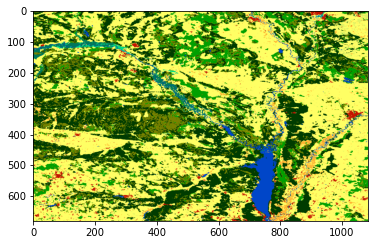

In [5]:
## TO FILE:
from shapely.geometry.base import BaseGeometry
from typing import Union, List, Tuple, Iterable, Dict, Any

def shapely_to_frame(shapes: Union[BaseGeometry, Union[BaseGeometry]], 
                     attributes: Dict[str, Any] = {}, 
                     crs: str = None, 
                     **kwargs):       
    """Convenience function to turn shapely objects into geopandas dataframes"""
    
    is_multiple = isinstance(shapes, Iterable)
        
    data = {"geometry": shapes if is_multiple else [shapes]}
    for key, val in attributes.items():
        data[key] = val if is_multiple else [val]
        
    for key, val in kwargs.items():
        data[key] = val if is_multiple else [val]
    
    return gpd.GeoDataFrame(data, crs=crs)

# Next closer ROI: 30km buffer around exclusion zones (reduced human activity)
buffer_size = 30 # in km (preferred CRS: UTM 35 is in m)

# Generate ROIs from exclusion zones: 
roi0 = shapely_to_frame(nuclear_plant, crs=WGS84, name="Nuclear Plant")
roi1 = chernobyl_exclusion_zone.append(polesie_exclusion_zone)

# Generate (exclusion_zone + buffer) and (exclusion_zone + 2*buffer) ROIs
roi3_outline = roi1.to_crs(PREFERRED_CRS).buffer(2*buffer_size*1e3).to_crs(WGS84).unary_union
roi2_outline = roi1.to_crs(PREFERRED_CRS).buffer(buffer_size*1e3).to_crs(WGS84).unary_union

roi3_shape = roi3_outline - roi2_outline
roi2_shape = roi2_outline - roi1.unary_union

roi3 = shapely_to_frame(roi3_shape, crs=WGS84, name=f"E+{2*buffer_size}")
roi2 = shapely_to_frame(roi2_shape, crs=WGS84, name=f"E+{buffer_size}")

# Get bounding box of all ROIs
bbox = shapely_to_frame(roi3_shape.envelope, crs=WGS84, name="bbox")

# Calculate the areas
rois = bbox.append([roi3, roi2, roi1, roi0]).reset_index(drop=True)
rois["area (km2)"] = rois.to_crs(PREFERRED_CRS).area / 1e6
rois

landcover_2015 = rasterio.open(esa_cci_landcovers[2015])

minx, miny, maxx, maxy = bbox.bounds.iloc[0].values
lat = (miny, maxy)
lon = (minx, maxx)

plt.imshow(classes_to_rgb(read_from_lat_lon(landcover_2015, 1, lat, lon)));

In [6]:
bbox_landcovers = {}

for year, data_path in tqdm.notebook.tqdm(esa_cci_landcovers.items()):
    
    out_tif = GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.tif"
    if os.path.exists(out_tif):
        logging.info(f"Processed data for {year} exists. Skipping")
        continue
    else:
        logging.info(f"Processing year {year}")
        
    # Crop to bbox around regions of interest
    with rasterio.open(data_path, "r") as data:
        out_img, out_transform = mask(data, shapes=bbox.geometry, crop=True)
        out_meta = data.meta.copy()
    
    # Update metadata for cropped region
    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": CRS.from_string(WGS84)})
    
    # Write clipping to disk
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
        
    bbox_landcovers[year] = (out_img, out_transform)

  0%|          | 0/24 [00:00<?, ?it/s]

INFO: Processed data for 1992 exists. Skipping
INFO: Processed data for 1993 exists. Skipping
INFO: Processed data for 1994 exists. Skipping
INFO: Processed data for 1995 exists. Skipping
INFO: Processed data for 1996 exists. Skipping
INFO: Processed data for 1997 exists. Skipping
INFO: Processed data for 1998 exists. Skipping
INFO: Processed data for 1999 exists. Skipping
INFO: Processed data for 2000 exists. Skipping
INFO: Processed data for 2001 exists. Skipping
INFO: Processed data for 2002 exists. Skipping
INFO: Processed data for 2003 exists. Skipping
INFO: Processed data for 2004 exists. Skipping
INFO: Processed data for 2005 exists. Skipping
INFO: Processed data for 2006 exists. Skipping
INFO: Processed data for 2007 exists. Skipping
INFO: Processed data for 2008 exists. Skipping
INFO: Processed data for 2009 exists. Skipping
INFO: Processed data for 2010 exists. Skipping
INFO: Processed data for 2011 exists. Skipping
INFO: Processed data for 2012 exists. Skipping
INFO: Process

## 2.2 Convert CRS from WGS84 to UTM35

In [7]:
import warnings

# To avoid pylandstats from cluttering our screen with warnings.
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='once')

In [10]:
input_filepaths = [GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.tif" for year in range(1992, 2016)]

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 299.587 m/pixel 
Y res: 299.589 m/pixel


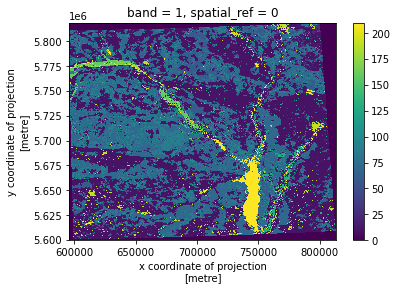

In [11]:
import rioxarray as rxr
# Load data in original CRS (WGS84)
data_wgs84 = rxr.open_rasterio(input_filepaths[-1])
data_wgs84.x.attrs["units"] = "degrees longitude"
data_wgs84.y.attrs["units"] = "degrees latitude"
# Reproject data to UTM34
pixel_size = 300  # m
data_utm35 = data_wgs84.rio.reproject(PREFERRED_CRS, resolution=(pixel_size, pixel_size))
data_utm35.plot()
# Calculate exact pixel size
x_res = abs(data_utm35.x.data[-1] - data_utm35.x.data[0]) / len(data_utm35.x.data)
y_res = abs(data_utm35.y.data[-1] - data_utm35.y.data[0]) / len(data_utm35.y.data)
print(f"X res: {x_res:.3f} m/pixel \nY res: {y_res:.3f} m/pixel")
# Call in pylandstats
chernobyl_2015_utm35 = pls.Landscape(data_utm35.data.squeeze(), 
                                     res=(x_res, y_res), 
                                     nodata=0, 
                                     transform=data_utm35.rio.transform())

In [12]:
def cher_utm35(a):
    '''Repoject the data to UTM35'''
    data_wgs84 = rxr.open_rasterio(input_filepaths[a])
    data_wgs84.x.attrs["units"] = "degrees longitude"
    data_wgs84.y.attrs["units"] = "degrees latitude"
    pixel_size = 300  # m
    data_utm35 = data_wgs84.rio.reproject(PREFERRED_CRS,resolution=(pixel_size, pixel_size))
    data_utm35.plot()
    x_res = abs(data_utm35.x.data[a] - data_utm35.x.data[0]) / len(data_utm35.x.data)
    y_res = abs(data_utm35.y.data[a] - data_utm35.y.data[0]) / len(data_utm35.y.data)
    print(f"X res: {x_res:.3f} m/pixel \nY res: {y_res:.3f} m/pixel")
    chernobyl_utm35 = pls.Landscape(data_utm35.data.squeeze(), 
                                     res=(x_res, y_res), 
                                     nodata=0, 
                                     transform=data_utm35.rio.transform())
    return chernobyl_utm35

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 299.174 m/pixel 
Y res: 299.178 m/pixel


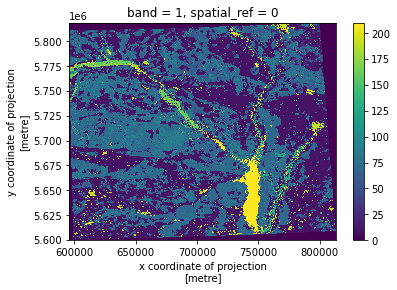

In [13]:
chernobyl_2014_utm35 = cher_utm35(-2) #2014 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 298.760 m/pixel 
Y res: 298.767 m/pixel


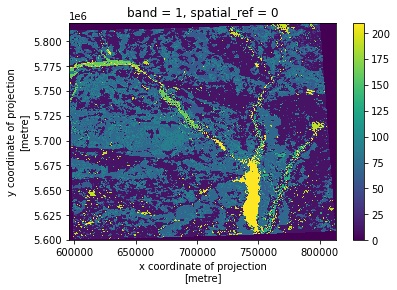

In [14]:
chernobyl_2013_utm35 = cher_utm35(-3) #2013 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 298.347 m/pixel 
Y res: 298.356 m/pixel


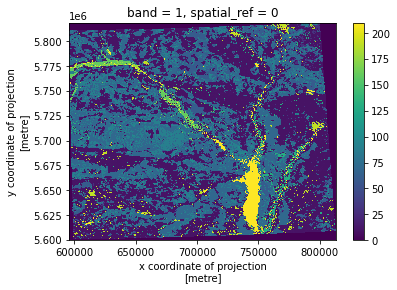

In [15]:

chernobyl_2012_utm35 = cher_utm35(-4) #2012 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 297.934 m/pixel 
Y res: 297.945 m/pixel


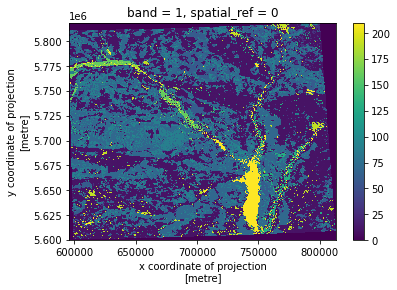

In [16]:

chernobyl_2011_utm35 = cher_utm35(-5) #2011 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 297.521 m/pixel 
Y res: 297.534 m/pixel


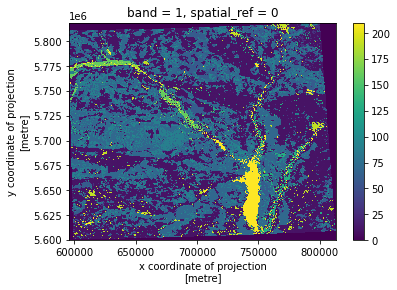

In [17]:

chernobyl_2010_utm35 = cher_utm35(-6) #2010 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 297.107 m/pixel 
Y res: 297.123 m/pixel


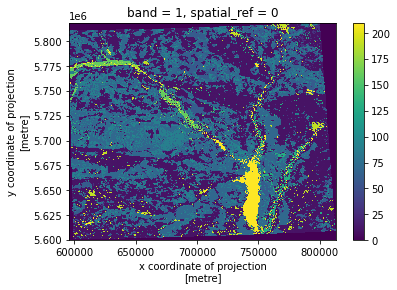

In [18]:

chernobyl_2009_utm35 = cher_utm35(-7) #2009 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 296.694 m/pixel 
Y res: 296.712 m/pixel


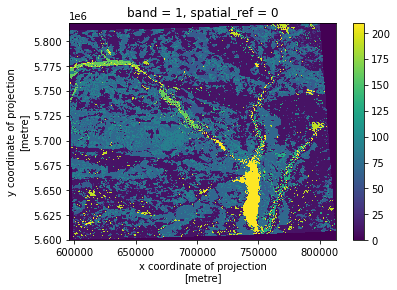

In [19]:

chernobyl_2008_utm35 = cher_utm35(-8) #2008 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 296.281 m/pixel 
Y res: 296.301 m/pixel


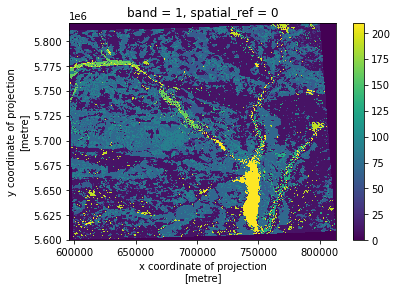

In [20]:

chernobyl_2007_utm35 = cher_utm35(-9) #2007 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 295.868 m/pixel 
Y res: 295.890 m/pixel


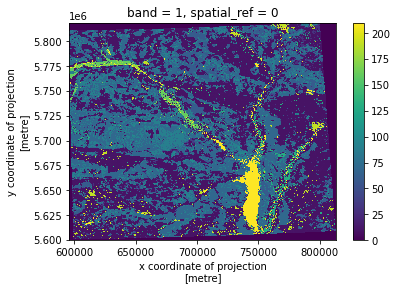

In [21]:

chernobyl_2006_utm35 = cher_utm35(-10) #2006 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 295.455 m/pixel 
Y res: 295.479 m/pixel


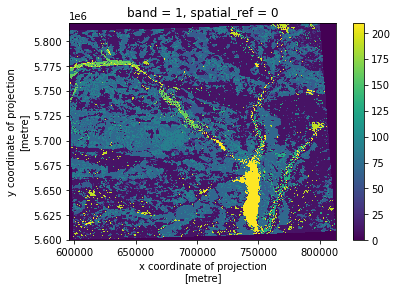

In [22]:

chernobyl_2005_utm35 = cher_utm35(-11) #2005 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 295.041 m/pixel 
Y res: 295.068 m/pixel


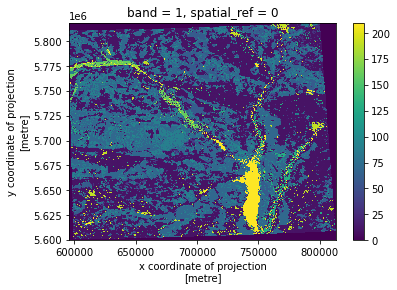

In [23]:

chernobyl_2004_utm35 = cher_utm35(-12) #2004 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 294.628 m/pixel 
Y res: 294.658 m/pixel


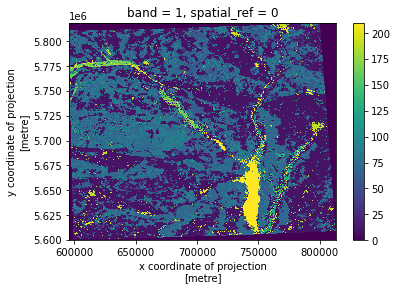

In [24]:

chernobyl_2003_utm35 = cher_utm35(-13) #2003 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 294.215 m/pixel 
Y res: 294.247 m/pixel


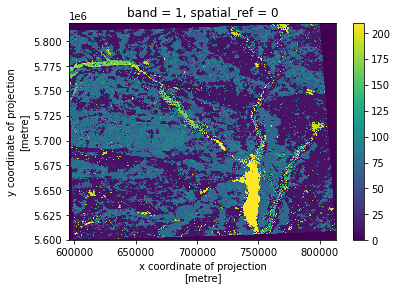

In [25]:

chernobyl_2002_utm35 = cher_utm35(-14) #2002 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 293.802 m/pixel 
Y res: 293.836 m/pixel


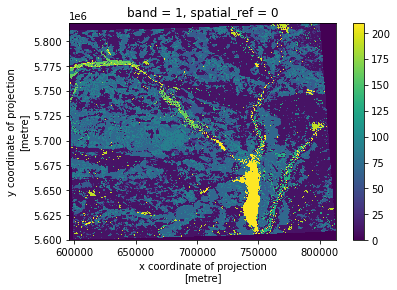

In [26]:

chernobyl_2001_utm35 = cher_utm35(-15) #2001 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 3.306 m/pixel 
Y res: 3.288 m/pixel


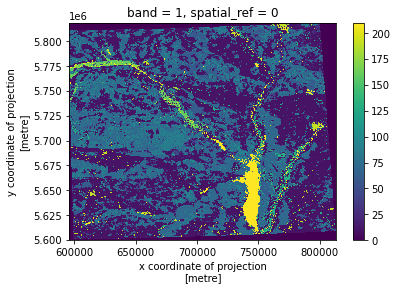

In [27]:

chernobyl_2000_utm35 = cher_utm35(8) #2000 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 2.893 m/pixel 
Y res: 2.877 m/pixel


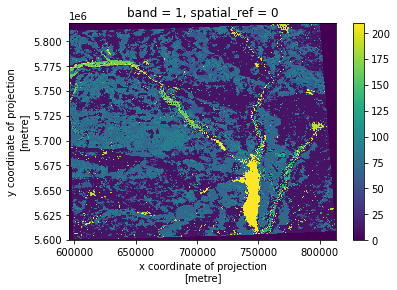

In [28]:

chernobyl_1999_utm35 = cher_utm35(7) #1999 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 2.479 m/pixel 
Y res: 2.466 m/pixel


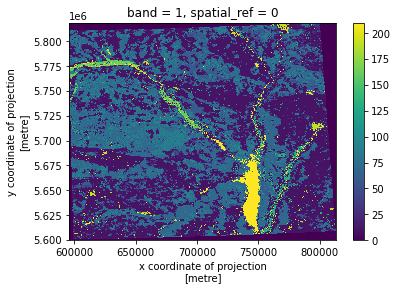

In [29]:

chernobyl_1998_utm35 = cher_utm35(6) #1998 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 2.066 m/pixel 
Y res: 2.055 m/pixel


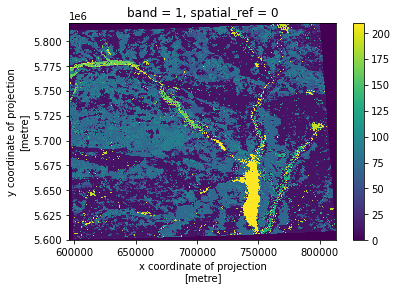

In [30]:

chernobyl_1997_utm35 = cher_utm35(5) #1997 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 1.653 m/pixel 
Y res: 1.644 m/pixel


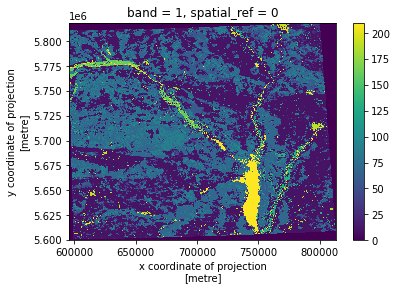

In [31]:

chernobyl_1996_utm35 = cher_utm35(4) #1996 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 1.240 m/pixel 
Y res: 1.233 m/pixel


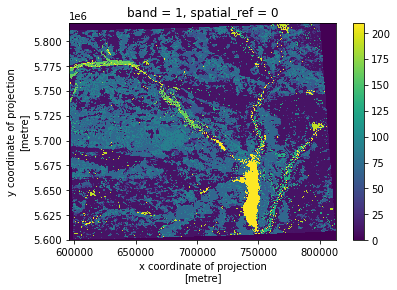

In [32]:

chernobyl_1995_utm35 = cher_utm35(3) #1995 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 0.826 m/pixel 
Y res: 0.822 m/pixel


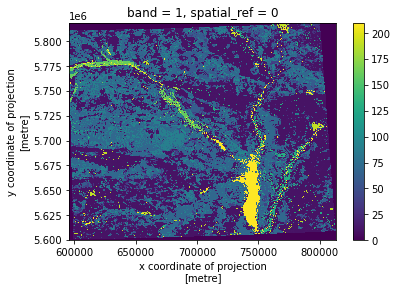

In [33]:

chernobyl_1994_utm35 = cher_utm35(2) #1994 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 0.413 m/pixel 
Y res: 0.411 m/pixel


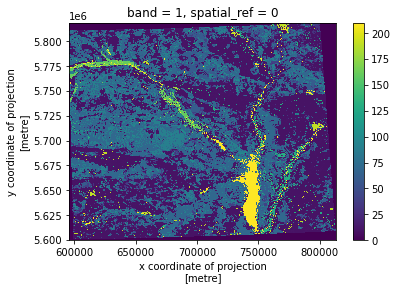

In [34]:

chernobyl_1993_utm35 = cher_utm35(1) #1993 Chernobyl

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


X res: 0.000 m/pixel 
Y res: 0.000 m/pixel


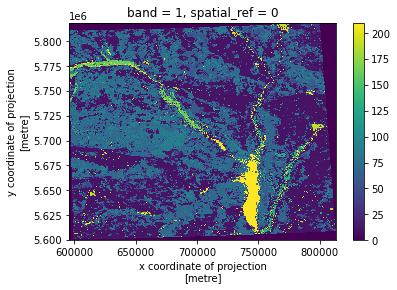

In [35]:

chernobyl_1992_utm35 = cher_utm35(0) #1992 Chernobyl

In [36]:
cher_sta = [chernobyl_1992_utm35,
            chernobyl_1993_utm35,
            chernobyl_1994_utm35,
            chernobyl_1995_utm35,
            chernobyl_1996_utm35,
            chernobyl_1997_utm35,
            chernobyl_1998_utm35,
            chernobyl_1999_utm35,
            chernobyl_2000_utm35,
            chernobyl_2001_utm35,
            chernobyl_2002_utm35,
            chernobyl_2003_utm35,
            chernobyl_2004_utm35,
            chernobyl_2005_utm35,
            chernobyl_2006_utm35,
            chernobyl_2007_utm35,
            chernobyl_2008_utm35,
            chernobyl_2009_utm35,
            chernobyl_2010_utm35,
            chernobyl_2011_utm35,
            chernobyl_2012_utm35,
            chernobyl_2013_utm35,
            chernobyl_2014_utm35,
            chernobyl_2015_utm35]
cher_sta = pls.SpatioTemporalAnalysis(cher_sta, dates = range(1992, 2016))

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Metrics spatio-temporal analysis

In [37]:
class_metrics = [
   'total_area','proportion_of_landscape', 
    'edge_density','total_edge',
    'number_of_patches', 'patch_density',
    'effective_mesh_size','landscape_shape_index'
]

landscape_metrics= [
    'total_area', 'patch_density',
    'number_of_patches', 'total_edge',
    'edge_density', 'landscape_shape_index',
    'contagion', 'shannon_diversity_index',
    'effective_mesh_size'
]

#landscape metrics
cher_sta.compute_landscape_metrics_df(metrics = landscape_metrics)

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1102: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / self.landscape_area
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1279: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / self.landscape_area
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:342: RuntimeWarning: invalid value encountered in true_divide
  area_cells_ser = area_ser / self.cell_area
/home/users/lyl

metric,total_area,patch_density,number_of_patches,total_edge,edge_density,landscape_shape_index,contagion,shannon_diversity_index,effective_mesh_size
dates,,,,,,,,,
1992,0.000000e+00,inf,29386.0,0.000000e+00,NaN,NaN,100.000000,NaN,NaN
1993,8.307229e+00,3.537522e+05,29387.0,1.158846e+05,13949.853736,101.552995,50.248203,1.885577,0.253213
1994,3.322891e+01,8.844406e+04,29389.0,2.317643e+05,6974.778049,101.550850,50.239069,1.886052,1.012570
1995,7.476506e+01,3.898078e+04,29144.0,3.453398e+05,4619.000583,100.887359,50.713287,1.872686,2.354681
1996,1.329157e+02,2.191691e+04,29131.0,4.601491e+05,3461.962959,100.821751,50.748176,1.872198,4.189576
1997,2.076807e+02,1.403886e+04,29156.0,5.753397e+05,2770.308765,100.848764,50.782875,1.871263,6.439790
1998,2.990602e+02,9.757901e+03,29182.0,6.908347e+05,2310.018659,100.910701,50.772206,1.871604,9.265686
1999,4.070542e+02,7.165876e+03,29169.0,8.032386e+05,1973.296362,100.573353,51.000604,1.865115,12.149387
2000,5.316626e+02,5.496907e+03,29225.0,9.183539e+05,1727.324581,100.613630,51.018318,1.864366,15.820221


In [38]:
#class metrics
cher_sta.compute_class_metrics_df(metrics = class_metrics)

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1018: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / self.landscape_area
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1018: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / self.landscape_area
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1018: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / self.landscape_area
/home/users/l

metric              total_area  proportion_of_landscape  edge_density  \
class_val dates                                                         
10        1992        0.000000                 0.000000      0.000000   
          1993        3.054036                36.763597   7079.537462   
          1994       12.213902                36.756851   3539.445540   
          1995       28.188300                37.702505   2373.000535   
          1996       50.251919                37.807373   1781.000133   
...                        ...                      ...           ...   
210       2011   105944.575031                 2.439772      0.733720   
          2012   106264.553425                 2.440386      0.732984   
          2013   106790.382271                 2.445701      0.731702   
          2014   107425.305287                 2.453469      0.731654   
          2015   107721.448828                 2.453469      0.730650   

metric             total_edge  number_of_patches  patch_density  \
class_val dates                                                   
10        1992   0.000000e+00             2452.0            inf   
          1993   5.881134e+04             2455.0   2.955258e+04   
          1994   1.176119e+05             2459.0   7.400182e+03   
          1995   1.774175e+05             2151.0   2.877012e+03   
          1996   2.367228e+05             2115.0   1.591235e+03   
...                       ...                ...            ...   
210       2011   3.186105e+06              559.0   1.287308e-02   
          2012   3.191717e+06              558.0   1.281458e-02   
          2013   3.194943e+06              552.0   1.264184e-02   
          2014   3.203550e+06              539.0   1.231013e-02   
          2015   3.207975e+06              539.0   1.227629e-02   

metric           effective_mesh_size  landscape_shape_index  
class_val dates                                              
10        1992                   NaN                    NaN  
          1993              0.221792              84.850491  
          1994              0.886887              84.850039  
          1995              2.062615              84.259702  
          1996              3.692796              84.204515  
...                              ...                    ...  
210       2011           1073.222651              24.484502  
          2012           1076.196206              24.493537  
          2013           1097.235032              24.484308  
          2014           1126.028696              24.404738  
          2015           1129.132863              24.404642  

[456 rows x 8 columns]

### Legend for class value:

|  Class Value   | Label  |
|  :----:  | :----:  |
| 10  | Cropland, rainfed |
| 11  | Herbaceous cover |
| 30 | Mosaic cropland (>50%)/natural vegetation (tree, shrub, herbaceous cover)(<50%) |
| 40 | Mosaic natural vegetation (tree, shrub, herbaceous cover) (>50%) / cropland (<50%) |
| 60 | Tree cover, broadleaved, deciduous, closed to open (>15%) |
| 61 | Tree cover, broadleaved, deciduous, closed (>40%) |
| 70 | Tree cover, :needleleaved, evergreen, closed to open (>15%) |
| 90 | Tree cover, mixed leaf type (broadleaved and needleleaved) |
| 100 | Mosaic tree and shrub (>50%) / herbaceous cover (<50%) |
| 110 | Mosaic herbaceous cover (>50%) / tree and shrub (<50%) |
| 130 | Grassland |
| 150 | Sparse vegetation (tree, shrub, herbaceous cover) (<15%) |
| 160 | Tree cover, flooded, fresh or brakish water |
| 180 | Shrub or herbaceous cover, flooded, fresh/saline/brakish water |
| 190 | Urban areas |
| 200 | Bare areas |
| 210 | Water bodies |

## 3.1 Plotting the temporal variation 

### 3.1.1 The temporal variation for landscape level

/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1102: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / self.landscape_area
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:1279: RuntimeWarning: invalid value encountered in double_scalars
  return numerator / self.landscape_area
/home/users/lyl1104/gtc-biodiversity/env/lib/python3.8/site-packages/pylandstats/landscape.py:342: RuntimeWarning: invalid value encountered in true_divide
  area_cells_ser = area_ser / self.cell_area
/home/users/lyl

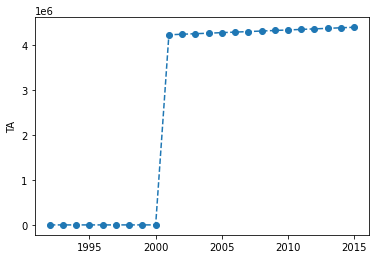

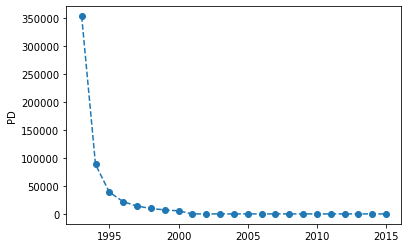

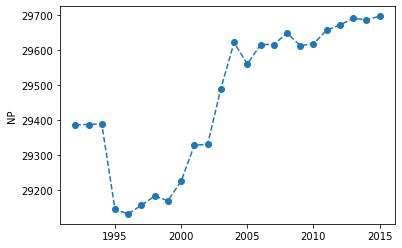

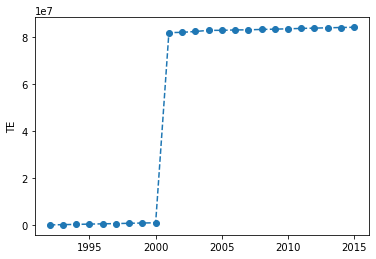

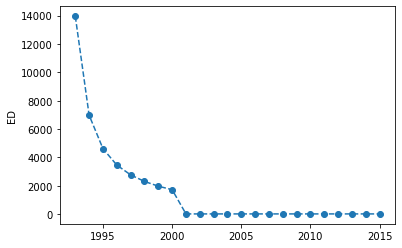

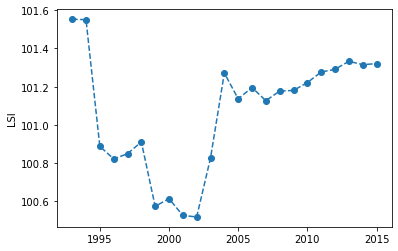

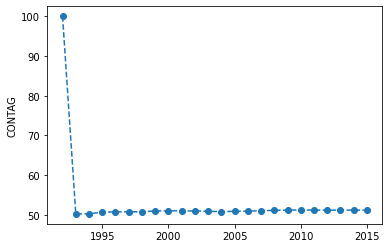

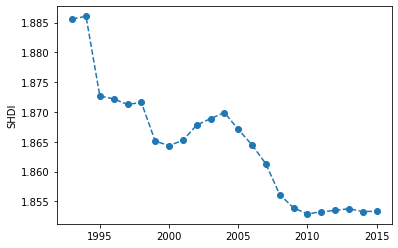

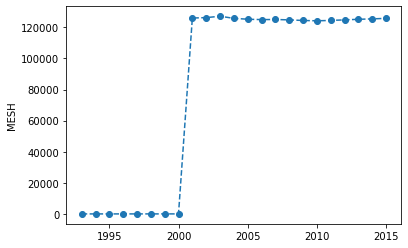

In [39]:
for i, metric in enumerate(landscape_metrics, start=1):
    
    cher_sta.plot_metric(metric)
    

Figures for hte landscape level of the whole region.